In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from pkgcurvas import curva3d, sigmoide, elipse, clotoide, gausiana
from scipy.interpolate import splprep, BSpline
from scipy.integrate import solve_ivp

from pkgmrusa import trayec_der, triedoFrenet, edofun_mr, finalVia, fuerzaNormal, energia, aceleracion, paradaVagon, aceleratg, animaVagon

In [14]:
def spline_xyz(puntos_xyz, s=0.0, k=3):
    """
    puntos_xyz: array-like de shape (N,3) con columnas (x,y,z)
    Devuelve: (curva, u) igual que spline_xz pero en 3D real
    """
    P = np.asarray(puntos_xyz, dtype=float)
    x, y, z = P[:, 0], P[:, 1], P[:, 2]

    tck, u = splprep([x, y, z], s=s, k=k)
    t, c_list, k_out = tck
    c = np.vstack(c_list).T
    curva = BSpline(t, c, k_out, extrapolate=False)
    return curva, u

Generando secciones individuales...
  Loop generado: 80 puntos
  Radio: 4.0 m
  Altura máxima: 12.00 m
  Rango X: [-4.00, 4.00] m
  Puntos generados (colina): 65
  Altura máxima (colina): 15.00

Conectando secciones...
1. Sigmoide - Fin en: (15.00, 0.00, 10.04)
2. Giro 1   - Fin en: (35.00, 20.00, 10.04)
3. Loop     - Fin en: (35.00, 20.00, 10.04)
4. Giro 2   - Fin en: (10.00, 45.00, 10.04)
5. Colina   - Fin en: (-69.98, 46.61, 10.04)
6. Giro 3   - Fin en: (-85.28, 31.92, 10.04)
7. Recta    - Fin en: (-86.49, 1.94, 10.04)

✓ Trayectoria completa: 365 puntos
  Rango X: [-86.49, 35.00]
  Rango Y: [0.00, 46.61]
  Rango Z: [10.04, 89.96]

Generando visualizaciones...


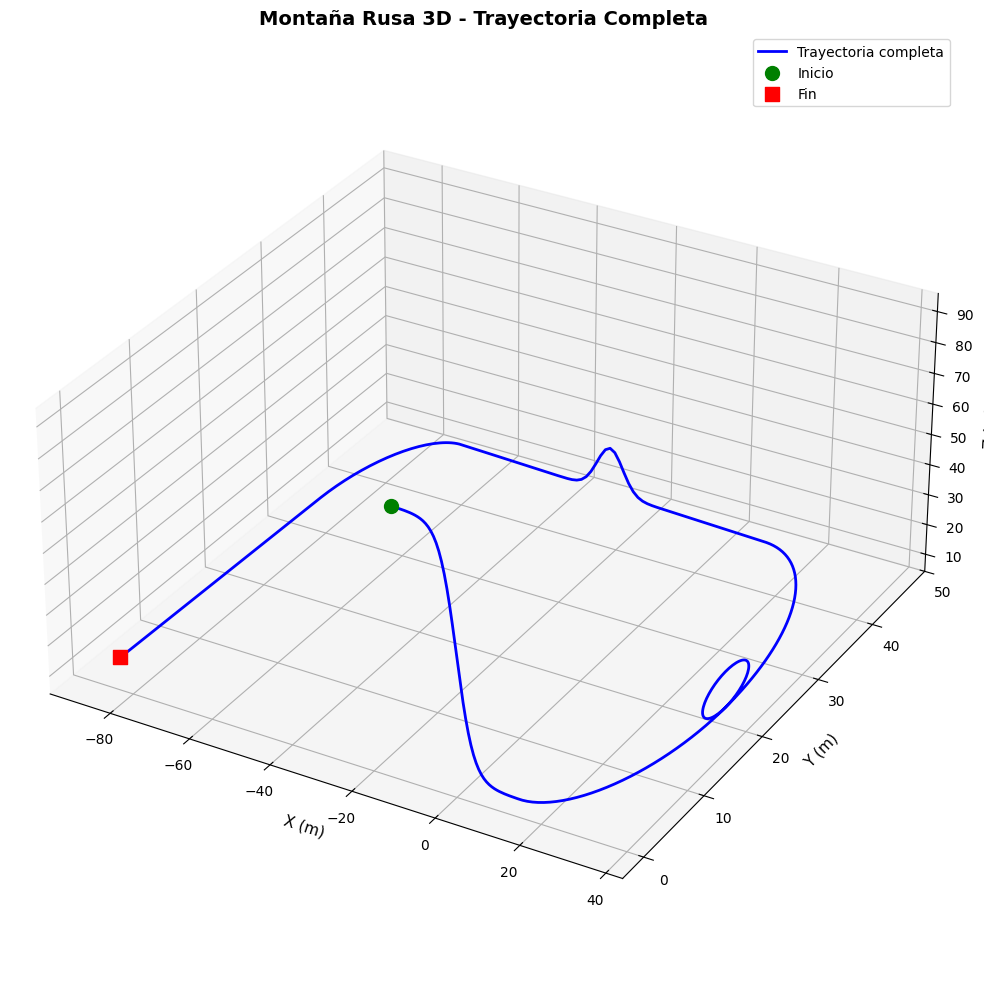

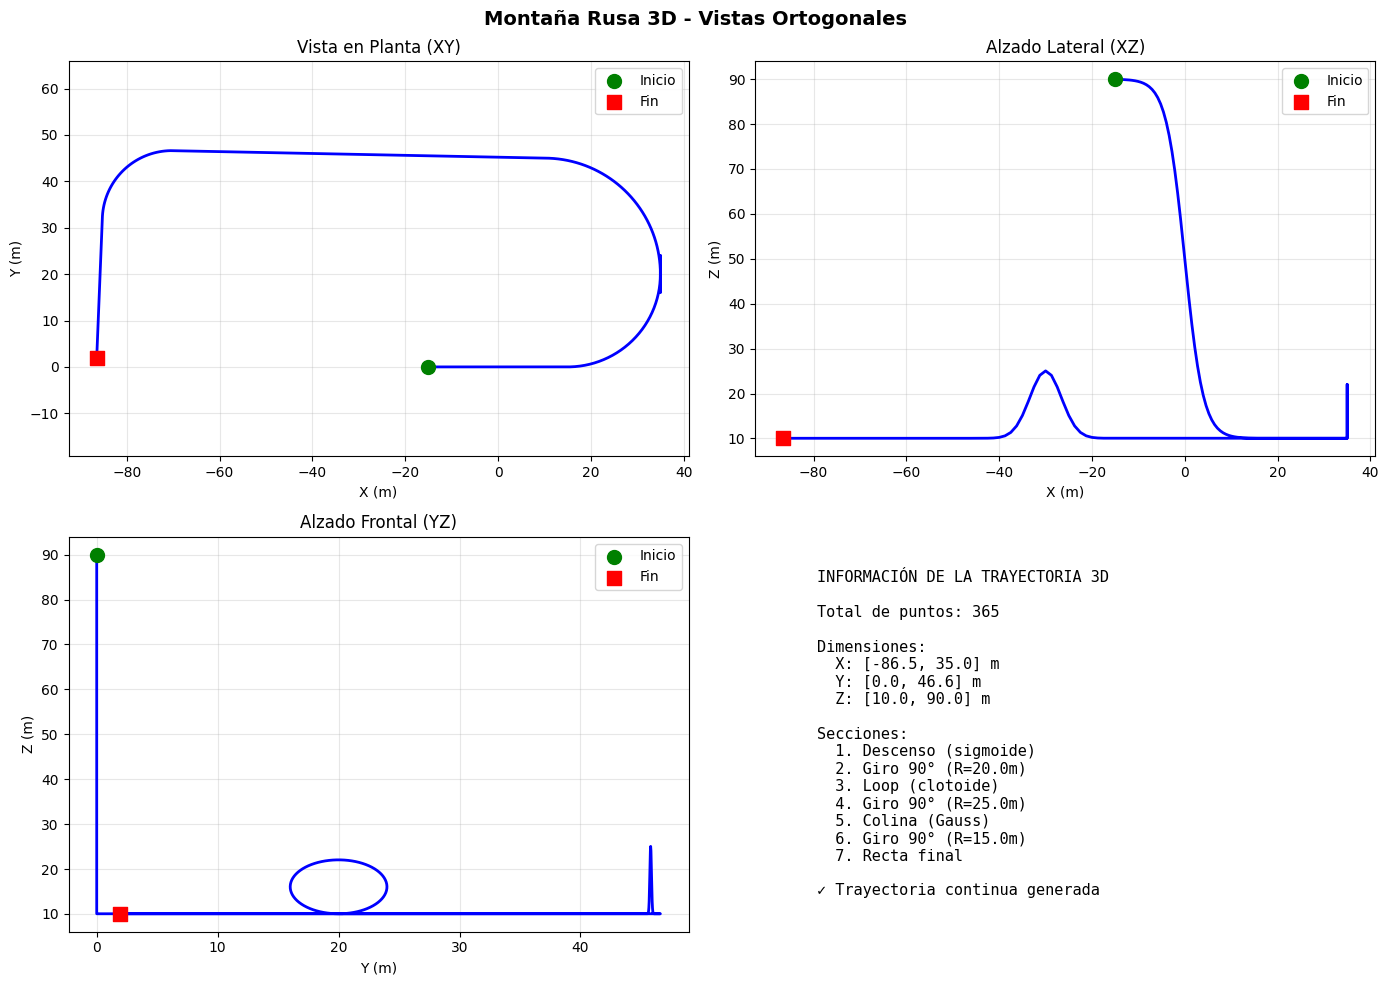


PUNTOS DE CONTROL LISTOS PARA PARAMETRIZACIÓN
Variable: puntos_control
Forma: (3, 365)
Tipo: <class 'numpy.ndarray'>

📝 SIGUIENTE PASO:
   Crear B-spline con estos puntos de control


In [23]:
# -*- coding: utf-8 -*-
# ============================================================================
# PARÁMETROS GEOMÉTRICOS
# ============================================================================

# Número de puntos por sección
n_sigmoide = 50
n_giro1 = 60
n_loop = 80
n_giro2 = 40
n_colina = 65
n_giro3 = 40
n_recta = 30

# Parámetros de las curvas
R1 = 20.0
R2 = 25.0
R3 = 15.0

A_sigmoide = 80.0
s_sigmoide = 0.5

A_loop = 4.0
t0_loop = 0.0

A_gauss = 15.0
s_gauss = 0.3

# ============================================================================
# FUNCIONES AUXILIARES PARA TRANSFORMACIONES
# ============================================================================

def trasladar(puntos, desplazamiento):
    """Trasladar puntos en 3D"""
    desp = np.array(desplazamiento).reshape(3, 1)
    return puntos + desp

def rotar_z(puntos, angulo):
    """Rotar puntos alrededor del eje Z"""
    c, s = np.cos(angulo), np.sin(angulo)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])
    return R @ puntos

def rotar_y(puntos, angulo):
    """Rotar puntos alrededor del eje Y"""
    c, s = np.cos(angulo), np.sin(angulo)
    R = np.array([[ c, 0, s],
                  [ 0, 1, 0],
                  [-s, 0, c]])
    return R @ puntos

def rotar_x(puntos, angulo):
    """Rotar puntos alrededor del eje X"""
    c, s = np.cos(angulo), np.sin(angulo)
    R = np.array([[1,  0, 0],
                  [0,  c, -s],
                  [0,  s,  c]])
    return R @ puntos

# ============================================================================
# GENERAR SECCIONES INDIVIDUALES
# ============================================================================

print("Generando secciones individuales...")

# 1. DESCENSO (SIGMOIDE)
p_sigmoide = np.linspace(-15, 15, n_sigmoide)
sigmoide_pts = curva3d('s', p_sigmoide, A_sigmoide, [0, 0, 10], 0, 'xz', [s_sigmoide])

# 2. GIRO 1 (R=20)
theta = np.linspace(-np.pi/2, 0, n_giro1)
x = R1 * np.cos(theta)
y = R1 + R1 * np.sin(theta)
z = np.zeros_like(theta)
giro1_pts = np.vstack([x, y, z])

# 3. LOOP (Clotoide) -> (en realidad círculo vertical que tú has definido)
kz = 1.5  # Factor de estirado vertical
theta_loop = np.linspace(0, 2*np.pi, n_loop)
R_loop = A_loop
x_loop = R_loop * np.sin(theta_loop)
y_loop = np.zeros_like(theta_loop)
z_loop = R_loop * kz * (1 - np.cos(theta_loop))
loop_pts = np.vstack([x_loop, y_loop, z_loop])

# 4. GIRO 2 (R=25)  (lo dejas tal cual lo tienes)
theta = np.linspace(0, np.pi/2, n_giro2)
x = R2 * np.cos(theta)
y = R2 * np.sin(theta)
z = np.zeros_like(theta)
giro2_pts = np.vstack([x, y, z])

print(f"  Loop generado: {loop_pts.shape[1]} puntos")
print(f"  Radio: {R_loop} m")
print(f"  Altura máxima: {np.max(loop_pts[2]):.2f} m")
print(f"  Rango X: [{np.min(loop_pts[0]):.2f}, {np.max(loop_pts[0]):.2f}] m")

# 5. COLINA (Gauss)  (lo dejas tal cual lo tienes, solo arreglo el print que te rompe)
L_colina = 80.0  # longitud horizontal de la colina (m)

p_gauss = np.linspace(-2.5, 2.5, n_colina)
gauss_xy = curva3d(
    tipo='g',
    p=p_gauss,
    A=A_gauss,
    C=[0, 0, 0],
    paso=0,
    plano='xy',
    args=[s_gauss]
)
gauss_xz = rotar_x(gauss_xy, np.pi/2)
gauss_xz[0] = np.linspace(0, L_colina, n_colina)
gauss_xz[2] = gauss_xz[2] - gauss_xz[2, 0]

print(f"  Puntos generados (colina): {gauss_xz.shape[1]}")
print(f"  Altura máxima (colina): {gauss_xz[2].max():.2f}")

# ============================================================================
# CONECTAR SECCIONES
# ============================================================================

print("\nConectando secciones...")

# Iniciar con la sigmoide (ya está bien posicionada)
trayectoria = [sigmoide_pts]
pos_actual = sigmoide_pts[:, -1]
print(f"1. Sigmoide - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 2. GIRO 1
inicio_giro1 = giro1_pts[:, 0]
desplazamiento = pos_actual - inicio_giro1
giro1_final = trasladar(giro1_pts, desplazamiento)
trayectoria.append(giro1_final)
pos_actual = giro1_final[:, -1]
print(f"2. Giro 1   - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 3. LOOP
loop_rotado = rotar_z(loop_pts, np.pi/2)
inicio_loop = loop_rotado[:, 0]
desplazamiento = pos_actual - inicio_loop
loop_final = trasladar(loop_rotado, desplazamiento)
trayectoria.append(loop_final)
pos_actual = loop_final[:, -1]
print(f"3. Loop     - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 4. GIRO 2
inicio_giro2 = giro2_pts[:, 0]
desplazamiento = pos_actual - inicio_giro2
giro2_final = trasladar(giro2_pts, desplazamiento)
trayectoria.append(giro2_final)
pos_actual = giro2_final[:, -1]
print(f"4. Giro 2   - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 5. COLINA (Campana Gauss)
t = trayectoria[-1][:, -1] - trayectoria[-1][:, -2]   # vector tangente aproximado
ang = np.arctan2(t[1], t[0])                           # ángulo en XY
gauss_orientada = rotar_z(gauss_xz, ang)

inicio_colina = gauss_orientada[:, 0]
desplazamiento = pos_actual - inicio_colina
colina_final = trasladar(gauss_orientada, desplazamiento)

trayectoria.append(colina_final)
pos_actual = colina_final[:, -1]
print(f"5. Colina   - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 6. GIRO 3: giro plano 90° a izquierdas, alineado con la tangente de salida de la colina
t = trayectoria[-1][:, -1] - trayectoria[-1][:, -2]
ang0 = np.arctan2(t[1], t[0])

theta3 = np.linspace(-np.pi/2, 0, n_giro3)
x3 = R3 * np.cos(theta3)
y3 = R3 + R3 * np.sin(theta3)
z3 = np.zeros_like(theta3)
giro3_base = np.vstack([x3, y3, z3])

giro3_orientado = rotar_z(giro3_base, ang0)

inicio_giro3 = giro3_orientado[:, 0]
desplazamiento = pos_actual - inicio_giro3
giro3_final = trasladar(giro3_orientado, desplazamiento)

trayectoria.append(giro3_final)
pos_actual = giro3_final[:, -1]
print(f"6. Giro 3   - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# 7. RECTA FINAL: en la dirección de salida del giro 3
t_out = giro3_final[:, -1] - giro3_final[:, -2]
u = t_out / np.linalg.norm(t_out)

L_recta = 30.0
s = np.linspace(0, L_recta, n_recta)
recta_pts = pos_actual.reshape(3, 1) + u.reshape(3, 1) * s.reshape(1, -1)

trayectoria.append(recta_pts)
pos_actual = recta_pts[:, -1]
print(f"7. Recta    - Fin en: ({pos_actual[0]:.2f}, {pos_actual[1]:.2f}, {pos_actual[2]:.2f})")

# ============================================================================
# UNIR TODAS LAS SECCIONES EN UN SOLO ARRAY
# ============================================================================

puntos_control = np.hstack(trayectoria)

print(f"\n✓ Trayectoria completa: {puntos_control.shape[1]} puntos")
print(f"  Rango X: [{puntos_control[0].min():.2f}, {puntos_control[0].max():.2f}]")
print(f"  Rango Y: [{puntos_control[1].min():.2f}, {puntos_control[1].max():.2f}]")
print(f"  Rango Z: [{puntos_control[2].min():.2f}, {puntos_control[2].max():.2f}]")

# ============================================================================
# VISUALIZACIÓN
# ============================================================================

print("\nGenerando visualizaciones...")

# Figura 1: Vista 3D completa
fig1 = plt.figure(figsize=(14, 10))
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot(
    puntos_control[0], puntos_control[1], puntos_control[2],
    'b-', linewidth=2, label='Trayectoria completa'
)

ax1.scatter(*puntos_control[:, 0], color='green', s=100, marker='o',
            label='Inicio', zorder=5)
ax1.scatter(*puntos_control[:, -1], color='red', s=100, marker='s',
            label='Fin', zorder=5)

ax1.set_xlabel('X (m)', fontsize=11)
ax1.set_ylabel('Y (m)', fontsize=11)
ax1.set_zlabel('Z (m)', fontsize=11)
ax1.set_title('Montaña Rusa 3D - Trayectoria Completa', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Ajustar aspecto (NO uso ptp; dejo tu ajuste fijo)
ax1.set_box_aspect([1, 1, 0.5])

plt.tight_layout()
plt.show()

# Figura 2: Vistas ortogonales
fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

# Vista XY (planta)
ax_xy = axes[0, 0]
ax_xy.plot(puntos_control[0], puntos_control[1], 'b-', linewidth=2)
ax_xy.scatter(puntos_control[0, 0], puntos_control[1, 0],
              color='green', s=100, marker='o', label='Inicio', zorder=5)
ax_xy.scatter(puntos_control[0, -1], puntos_control[1, -1],
              color='red', s=100, marker='s', label='Fin', zorder=5)
ax_xy.set_xlabel('X (m)')
ax_xy.set_ylabel('Y (m)')
ax_xy.set_title('Vista en Planta (XY)')
ax_xy.grid(True, alpha=0.3)
ax_xy.legend()
ax_xy.axis('equal')

# Vista XZ (alzado lateral)
ax_xz = axes[0, 1]
ax_xz.plot(puntos_control[0], puntos_control[2], 'b-', linewidth=2)
ax_xz.scatter(puntos_control[0, 0], puntos_control[2, 0],
              color='green', s=100, marker='o', label='Inicio', zorder=5)
ax_xz.scatter(puntos_control[0, -1], puntos_control[2, -1],
              color='red', s=100, marker='s', label='Fin', zorder=5)
ax_xz.set_xlabel('X (m)')
ax_xz.set_ylabel('Z (m)')
ax_xz.set_title('Alzado Lateral (XZ)')
ax_xz.grid(True, alpha=0.3)
ax_xz.legend()

# Vista YZ (alzado frontal)
ax_yz = axes[1, 0]
ax_yz.plot(puntos_control[1], puntos_control[2], 'b-', linewidth=2)
ax_yz.scatter(puntos_control[1, 0], puntos_control[2, 0],
              color='green', s=100, marker='o', label='Inicio', zorder=5)
ax_yz.scatter(puntos_control[1, -1], puntos_control[2, -1],
              color='red', s=100, marker='s', label='Fin', zorder=5)
ax_yz.set_xlabel('Y (m)')
ax_yz.set_ylabel('Z (m)')
ax_yz.set_title('Alzado Frontal (YZ)')
ax_yz.grid(True, alpha=0.3)
ax_yz.legend()

# Información
ax_info = axes[1, 1]
ax_info.axis('off')
info_text = f"""
INFORMACIÓN DE LA TRAYECTORIA 3D

Total de puntos: {puntos_control.shape[1]}

Dimensiones:
  X: [{puntos_control[0].min():.1f}, {puntos_control[0].max():.1f}] m
  Y: [{puntos_control[1].min():.1f}, {puntos_control[1].max():.1f}] m
  Z: [{puntos_control[2].min():.1f}, {puntos_control[2].max():.1f}] m

Secciones:
  1. Descenso (sigmoide)
  2. Giro 90° (R={R1}m)
  3. Loop (clotoide)
  4. Giro 90° (R={R2}m)
  5. Colina (Gauss)
  6. Giro 90° (R={R3}m)
  7. Recta final

✓ Trayectoria continua generada
"""
ax_info.text(0.1, 0.5, info_text, fontsize=11, family='monospace',
             verticalalignment='center')

plt.suptitle('Montaña Rusa 3D - Vistas Ortogonales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# GUARDAR PUNTOS DE CONTROL
# ============================================================================

print("\n" + "="*70)
print("PUNTOS DE CONTROL LISTOS PARA PARAMETRIZACIÓN")
print("="*70)
print("Variable: puntos_control")
print(f"Forma: {puntos_control.shape}")
print(f"Tipo: {type(puntos_control)}")
print("\n📝 SIGUIENTE PASO:")
print("   Crear B-spline con estos puntos de control")
print("="*70)


Puntos originales: 365
Puntos tras limpiar: 359


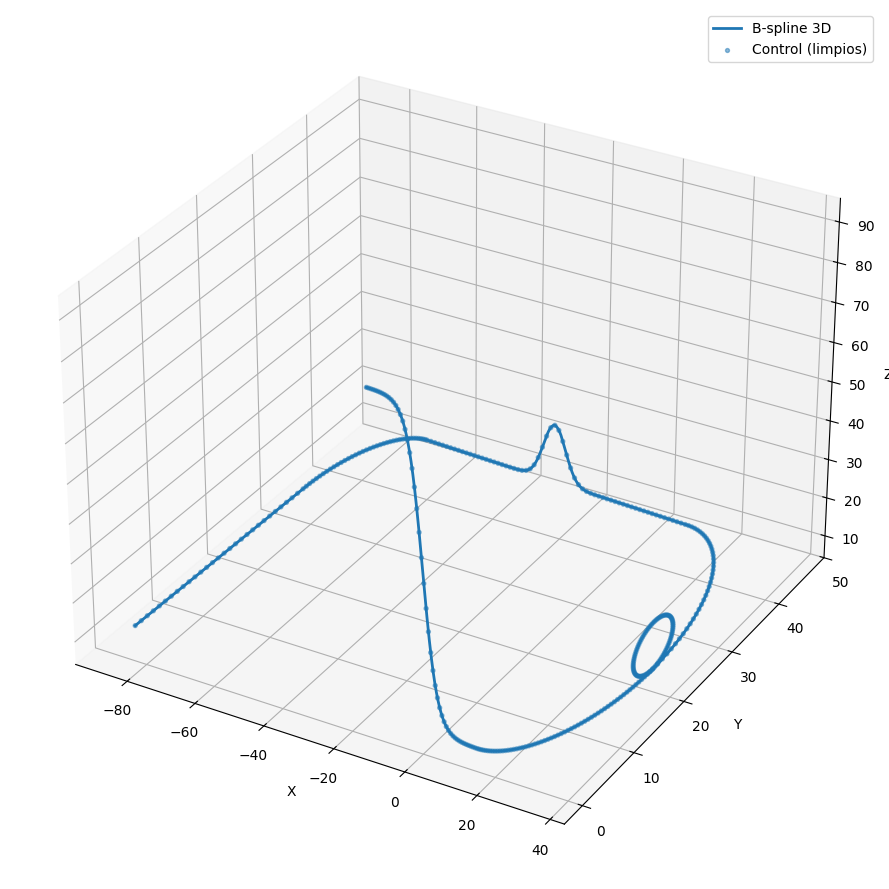

In [24]:
# ------------------------------------------------------------
# 1) Convertir puntos_control (3,N) -> (N,3)
# ------------------------------------------------------------
P = puntos_control.T  # (N,3)

# ------------------------------------------------------------
# 2) Limpiar: quitar NaNs y puntos consecutivos duplicados
# ------------------------------------------------------------
# Quitar no finitos
mask_finite = np.isfinite(P).all(axis=1)
P = P[mask_finite]

# Quitar duplicados consecutivos (distancia ~ 0)
eps = 1e-9
d = np.linalg.norm(np.diff(P, axis=0), axis=1)
keep = np.hstack(([True], d > eps))
P_clean = P[keep]

print("Puntos originales:", P.shape[0])
print("Puntos tras limpiar:", P_clean.shape[0])

# ------------------------------------------------------------
# 3) Ajustar spline (si aún falla, prueba s=1.0 o k=2)
# ------------------------------------------------------------
k = 3
if P_clean.shape[0] <= k:
    k = 2

curva, u = spline_xyz(P_clean, s=0.0, k=k)

# ------------------------------------------------------------
# 4) Evaluar y plotear
# ------------------------------------------------------------
t_eval = np.linspace(0, 1, 2000)
C = curva(t_eval)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(C[:,0], C[:,1], C[:,2], linewidth=2, label='B-spline 3D')
ax.scatter(P_clean[:,0], P_clean[:,1], P_clean[:,2], s=8, alpha=0.5, label='Control (limpios)')
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


EJECUTANDO COMPARACIÓN DE MÉTODOS (3D)
RK45    -> OK | pasos=72, t_final=13.833, u_final=1.00000
RK23    -> OK | pasos=327, t_final=13.812, u_final=0.99766
DOP853  -> OK | pasos=71, t_final=13.832, u_final=1.00000
Radau   -> OK | pasos=419, t_final=13.832, u_final=1.00000
BDF     -> OK | pasos=703, t_final=13.832, u_final=1.00000
LSODA   -> OK | pasos=406, t_final=13.726, u_final=0.98787

Generando gráficas...


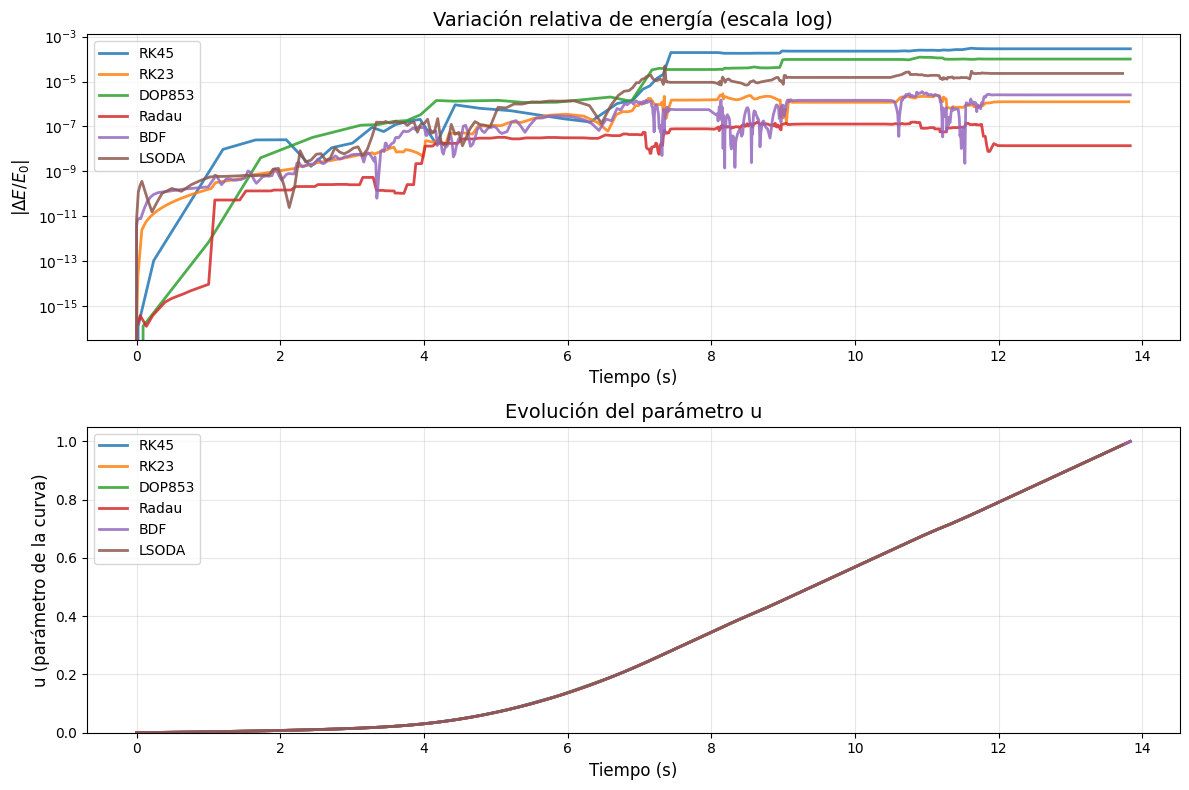


COMPARACIÓN DE MÉTODOS NUMÉRICOS (SISTEMA CONSERVATIVO) - 3D
Curva: B-spline 3D interpolado de la trayectoria de montaña rusa
Tolerancias: rtol=1e-06, atol=1e-09
Método   Status     Pasos   t_final   u_final       ΔE_min       ΔE_max     ΔE_final
----------------------------------------------------------------------------------------------------
RK45     OK            72    13.833   1.00000 -3.0261e-04 +2.0693e-05 -2.8584e-04
RK23     OK           327    13.812   0.99766 -2.8501e-06 +2.3953e-06 +1.2585e-06
DOP853   OK            71    13.832   1.00000 -4.0467e-09 +1.2154e-04 +9.9940e-05
Radau    OK           419    13.832   1.00000 -1.2876e-16 +1.5650e-07 +1.3966e-08
BDF      OK           703    13.832   1.00000 -3.5576e-06 +1.5580e-06 -2.5417e-06
LSODA    OK           406    13.726   0.98787 -4.9378e-05 +1.3878e-06 -2.2878e-05


In [31]:
# ============================================================
# FUNCIÓN WRAPPER SEGURA PARA EDO
# ============================================================

def edofun_mr_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """
    Wrapper seguro que evita evaluaciones fuera del dominio [0,1]
    y protege frente a divisiones por cero / NaN.
    """
    u, v = y

    # CRÍTICO: Proyectar u al dominio válido
    u = np.clip(u, 0.0, 1.0)

    try:
        from pkgmrusa import fuerzaNormal, aceleratg

        fuerzaN, baseLocal, ctes = fuerzaNormal(u, v, posyder, grav)

        # Evitar división por cero
        if abs(ctes[0]) < 1e-12:
            return [0.0, 0.0]

        du = v / ctes[0]
        dv = aceleratg(v, baseLocal, coefRoz, coefVis, fuerzaN, grav)

        # Opcional (pero ayuda a Radau/BDF/LSODA):
        # evitar explosiones numéricas si algo se dispara
        if not (np.isfinite(du) and np.isfinite(dv)):
            return [0.0, 0.0]

        return [du, dv]

    except Exception:
        return [0.0, 0.0]


# ============================================================
# EVENTOS SEGUROS
# ============================================================

def finalVia_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """Evento: llegada al final de la vía"""
    return y[0] - 1.0

finalVia_wrapper.terminal = True
finalVia_wrapper.direction = 0


def paradaVagon_wrapper(t, y, posyder, coefRoz, coefVis, grav):
    """Evento: parada del vagón"""
    return y[1]

paradaVagon_wrapper.terminal = True
paradaVagon_wrapper.direction = -1


# ============================================================
# CÓDIGO PRINCIPAL (COMPARACIÓN MÉTODOS) - 3D
# ============================================================

# --- Requisitos previos (deben existir en tu notebook) ---
# curva_bspline : tu BSpline 3D (vectorial) construida con spline_xyz
# trayec_der    : tu función para derivadas geométricas
# energia       : tu función de energía
#
# Ejemplo de uso previo:
# curva_bspline, u_knots = spline_xyz(P, s=0.0, k=3)
# derivs = trayec_der(curva_bspline)

derivs = trayec_der(curva)

# Parámetros físicos dados
g = 9.81              # Aceleración gravitatoria (m/s²)
mu = 0.0            # Coeficiente de fricción
ca = 0.0              # Coeficiente de resistencia aerodinámica
Sf = 2.0              # Superficie frontal (m²)
rho_aire = 1.225      # Densidad del aire (kg/m³)
v0 = 2.0              # Velocidad inicial (m/s)
masa = 800.0          # Masa del vagón (kg)

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

# Condiciones iniciales
y0 = [0.0, 1.0]   # u(0)=0, v(0)=0
t_end = 40.0

# Tolerancias
rtol = 1e-6
atol = 1e-9

metodos = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
resultados = {}

print("\n" + "="*80)
print("EJECUTANDO COMPARACIÓN DE MÉTODOS (3D)")
print("="*80)

for m in metodos:
    try:
        solver_config = {
            "method": m,
            "rtol": rtol,
            "atol": atol,
            "dense_output": True,
            "events": [finalVia_wrapper, paradaVagon_wrapper],
        }

        # Ajustes típicos para implícitos
        if m in ["Radau", "BDF"]:
            solver_config["max_step"] = 0.1
            solver_config["rtol"] = rtol / 10
            solver_config["atol"] = atol / 10

        sol = solve_ivp(
            edofun_mr_wrapper,
            t_span=(0.0, t_end),
            y0=y0,
            args=(derivs, coefRoz, coefVis, g),
            **solver_config
        )

        if not sol.success:
            resultados[m] = {"ok": False, "error": sol.message}
            print(f"{m:<7} -> FALLÓ: {sol.message}")
            continue

        # Extraer solución
        t = sol.t
        u = sol.y[0]
        v = sol.y[1]

        # Filtrado robusto (u dentro de [0,1] y finito)
        mask = (
            np.isfinite(t) &
            np.isfinite(u) &
            np.isfinite(v) &
            (u >= 0.0) & (u <= 1.0)
        )

        if not np.any(mask):
            resultados[m] = {"ok": False, "error": "No valid points after filtering"}
            print(f"{m:<7} -> FALLÓ: sin puntos válidos")
            continue

        t, u, v = t[mask], u[mask], v[mask]

        # Energía (segura)
        E = []
        for ui, vi in zip(u, v):
            try:
                Ei = energia(ui, vi, derivs[0], grav=g)
                E.append(Ei if np.isfinite(Ei) else np.nan)
            except Exception:
                E.append(np.nan)
        E = np.array(E)

        # Filtrar energía válida
        maskE = np.isfinite(E)
        if not np.any(maskE):
            resultados[m] = {"ok": False, "error": "Invalid energy"}
            print(f"{m:<7} -> FALLÓ: energía inválida")
            continue

        t, u, v, E = t[maskE], u[maskE], v[maskE], E[maskE]

        # Puntos suficientes
        if len(t) < 5:
            resultados[m] = {"ok": False, "error": f"Only {len(t)} valid points"}
            print(f"{m:<7} -> FALLÓ: solo {len(t)} puntos válidos")
            continue

        E0 = E[0]
        if abs(E0) < 1e-12:
            resultados[m] = {"ok": False, "error": "E0 too small"}
            print(f"{m:<7} -> FALLÓ: E0≈0")
            continue

        dE = (E - E0) / E0
        dEabs = np.abs(dE)

        resultados[m] = {
            "ok": True,
            "pasos": len(t) - 1,
            "t": t,
            "u": u,
            "v": v,
            "E": E,
            "dE": dE,
            "dEabs": dEabs,
            "dE_min": float(np.min(dE)),
            "dE_max": float(np.max(dE)),
            "dE_mean": float(np.mean(dE)),
            "dE_std": float(np.std(dE)),
            "dE_final": float(dE[-1]),
            "t_final": float(t[-1]),
            "u_final": float(u[-1]),
        }

        print(f"{m:<7} -> OK | pasos={resultados[m]['pasos']}, t_final={resultados[m]['t_final']:.3f}, u_final={resultados[m]['u_final']:.5f}")

    except Exception as e:
        resultados[m] = {"ok": False, "error": f"{type(e).__name__}: {str(e)}"}
        print(f"{m:<7} -> EXCEPCIÓN: {type(e).__name__}: {str(e)[:80]}")


# ============================================================
# GRÁFICAS
# ============================================================

print("\n" + "="*80)
print("Generando gráficas...")
print("="*80)

metodos_ok = [m for m in metodos if resultados.get(m, {}).get("ok", False)]

if len(metodos_ok) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # 1) |dE/E0| en escala log
    ax = axes[0]
    for m in metodos_ok:
        ax.semilogy(
            resultados[m]["t"],
            resultados[m]["dEabs"],
            label=m,
            linewidth=2,
            alpha=0.85
        )
    ax.set_xlabel("Tiempo (s)", fontsize=12)
    ax.set_ylabel(r"$|\Delta E / E_0|$", fontsize=12)
    ax.set_title("Variación relativa de energía (escala log)", fontsize=14)
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(fontsize=10, loc="best")

    # 2) u(t)
    ax = axes[1]
    for m in metodos_ok:
        ax.plot(
            resultados[m]["t"],
            resultados[m]["u"],
            label=m,
            linewidth=2,
            alpha=0.85
        )
    ax.set_xlabel("Tiempo (s)", fontsize=12)
    ax.set_ylabel("u (parámetro de la curva)", fontsize=12)
    ax.set_title("Evolución del parámetro u", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc="best")
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.show()
else:
    print("⚠ No hay métodos exitosos para graficar.")


# ============================================================
# TABLA RESUMEN
# ============================================================

print("\n" + "="*100)
print("COMPARACIÓN DE MÉTODOS NUMÉRICOS (SISTEMA CONSERVATIVO) - 3D")
print("Curva: B-spline 3D interpolado de la trayectoria de montaña rusa")
print(f"Tolerancias: rtol={rtol:.0e}, atol={atol:.0e}")
print("="*100)
print(f"{'Método':<8} {'Status':<8} {'Pasos':>7} {'t_final':>9} {'u_final':>9} "
      f"{'ΔE_min':>12} {'ΔE_max':>12} {'ΔE_final':>12}")
print("-"*100)

for m in metodos:
    if resultados.get(m, {}).get("ok", False):
        r = resultados[m]
        print(f"{m:<8} {'OK':<8} {r['pasos']:>7d} {r['t_final']:>9.3f} "
              f"{r['u_final']:>9.5f} {r['dE_min']:>+.4e} {r['dE_max']:>+.4e} "
              f"{r['dE_final']:>+.4e}")
    else:
        err = resultados.get(m, {}).get("error", "Sin info")
        if len(err) > 40:
            err = err[:37] + "..."
        print(f"{m:<8} {'FALLÓ':<8} {'-':>7s} {'-':>9s} {'-':>9s} "
              f"{'':>12s} {'':>12s} {err}")

print("="*100)


RESOLVIENDO PARA VARIOS MÉTODOS...

Resolviendo con método RK45...
✓ Solución obtenida exitosamente
  Número de pasos: 74
  Tiempo final: 12.77 s
  Posición final: u = 1.0000
  Velocidad final: v = 39.64 m/s
  ✓ Evento 'finalVia' activado en t = 12.77 s

Resolviendo con método RK23...
✓ Solución obtenida exitosamente
  Número de pasos: 307
  Tiempo final: 12.77 s
  Posición final: u = 1.0000
  Velocidad final: v = 39.65 m/s
  ✓ Evento 'finalVia' activado en t = 12.77 s

Resolviendo con método DOP853...
✓ Solución obtenida exitosamente
  Número de pasos: 74
  Tiempo final: 12.77 s
  Posición final: u = 1.0000
  Velocidad final: v = 39.65 m/s
  ✓ Evento 'finalVia' activado en t = 12.77 s

Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 233
  Tiempo final: 12.77 s
  Posición final: u = 1.0000
  Velocidad final: v = 39.65 m/s
  ✓ Evento 'finalVia' activado en t = 12.77 s

Resolviendo con método BDF...
✓ Solución obtenida exitosamente
  Número de pasos: 

C:\Users\miguel\AppData\Local\Temp\ipykernel_2344\1421540264.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


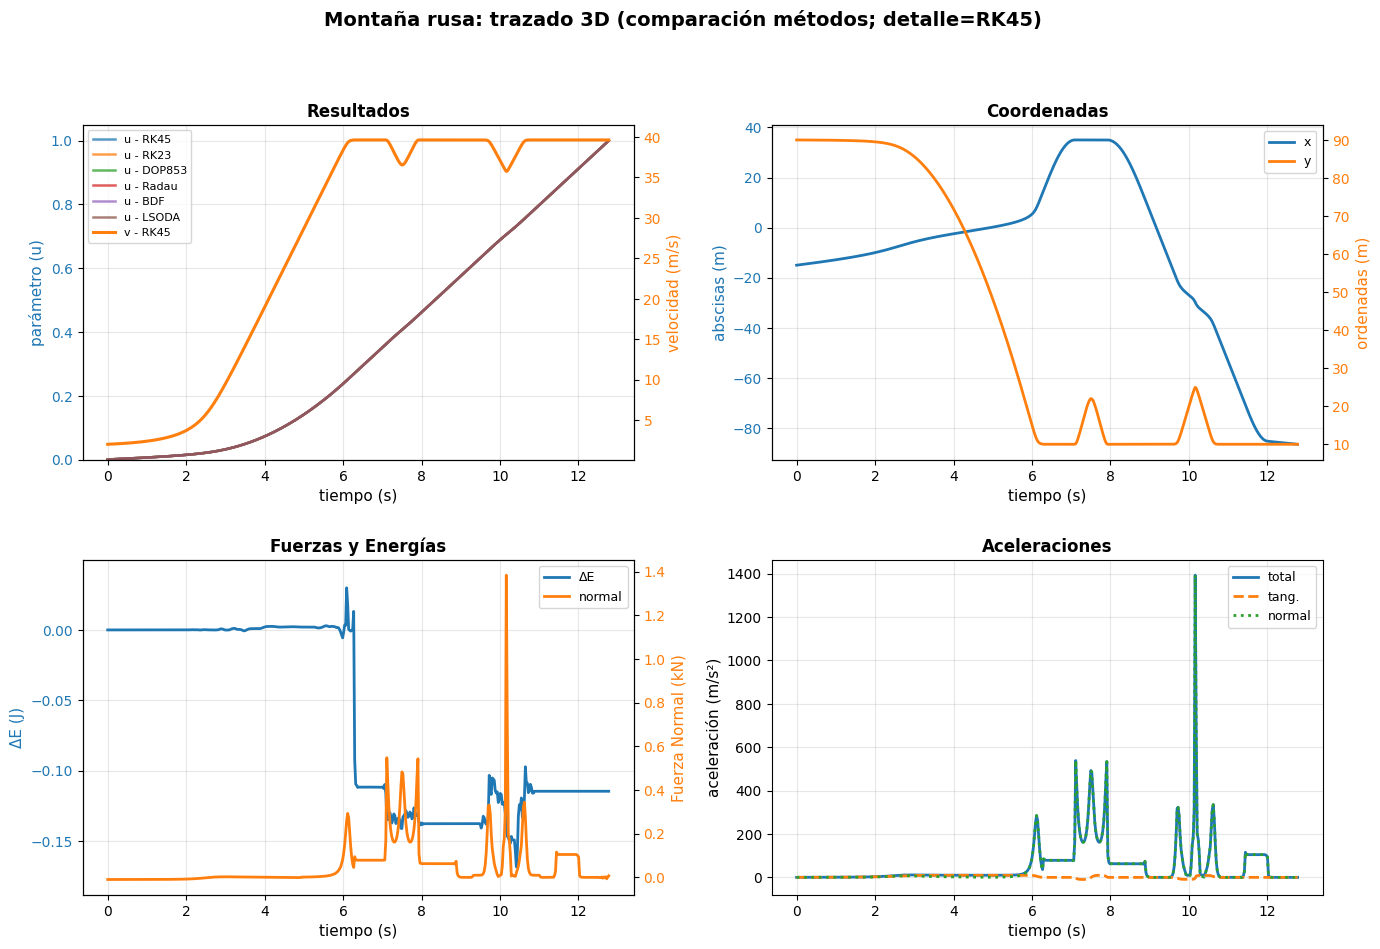


ESTADÍSTICAS DEL RECORRIDO
Método usado en detalle: RK45
Tiempo total:           12.77 s
Velocidad máxima:       39.64 m/s (142.72 km/h)
Velocidad media:        27.22 m/s (97.99 km/h)
Aceleración máxima:     1392.58 m/s² (141.96 g)
Fuerza normal máxima:   1383.45 N/kg (141.02 g)
Energía inicial:        884.47 J/kg
Energía final:          884.35 J/kg
Máx variación energía:  0.0190 % (conservativo)


In [34]:
# -*- coding: utf-8 -*-
# =====================================================================
# PARÁMETROS DEL PROBLEMA (igual que tu código)
# =====================================================================

g = 9.81
mu = 0.0
ca = 0.0
Sf = 2.0
rho_aire = 1.225
masa = 800.0

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

y0 = [0.0, 2.0]   # [u(0), v(0)]
t_end = 40.0

rtol = 1e-6
atol = 1e-9

# Comparación de métodos (mínimo cambio)
metodos = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
resultados = {}

# =====================================================================
# RESOLVER LA EDO PARA TODOS LOS MÉTODOS
# =====================================================================

print("\n" + "="*80)
print("RESOLVIENDO PARA VARIOS MÉTODOS...")
print("="*80)

for metodo in metodos:
    print(f"\nResolviendo con método {metodo}...")

    try:
        sol = solve_ivp(
            edofun_mr_wrapper,
            t_span=(0.0, t_end),
            y0=y0,
            args=(derivs, coefRoz, coefVis, g),
            method=metodo,
            events=[finalVia_wrapper, paradaVagon_wrapper],
            dense_output=True,
            rtol=rtol,
            atol=atol
        )

        if not sol.success:
            resultados[metodo] = {"ok": False, "error": sol.message}
            print(f"✗ FALLÓ: {sol.message}")
            continue

        resultados[metodo] = {"ok": True, "sol": sol}
        print("✓ Solución obtenida exitosamente")
        print(f"  Número de pasos: {len(sol.t)}")
        print(f"  Tiempo final: {sol.t[-1]:.2f} s")
        print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
        print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

        if sol.t_events[0].size > 0:
            print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
        if sol.t_events[1].size > 0:
            print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

    except Exception as e:
        resultados[metodo] = {"ok": False, "error": f"{type(e).__name__}: {e}"}
        print(f"✗ EXCEPCIÓN: {type(e).__name__}: {e}")

# Elegir método para gráficos detallados (mínimo cambio)
metodos_ok = [m for m in metodos if resultados[m].get("ok", False)]
if len(metodos_ok) == 0:
    raise RuntimeError("Ningún método ha producido una solución válida.")

# Método principal para cálculos caros (energía, fuerzas, aceleraciones)
metodo_plot = metodos_ok[0]   # o fija: metodo_plot = "Radau"
sol = resultados[metodo_plot]["sol"]

print("\n" + "="*80)
print(f"Usando '{metodo_plot}' para gráficos detallados (fuerzas/energías/aceleraciones)")
print("="*80)

# =====================================================================
# PREPARAR DATOS PARA GRAFICADO (igual que tu código)
# =====================================================================

n_puntos = 500
titulo = f"Montaña rusa: trazado 3D (comparación métodos; detalle={metodo_plot})"

time = np.linspace(0, sol.t[-1], n_puntos)
data = sol.sol(time)
u = data[0]
v = data[1]

# Calcular posición espacial
posicion = curva(u)

print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    x = posicion[0, :]
    y = posicion[2, :]
elif posicion.shape[1] == 3:
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# =====================================================================
# CALCULAR ENERGÍAS, FUERZAS Y ACELERACIONES (solo para metodo_plot)
# =====================================================================

E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)

        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN

        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis,
                                        fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr

    except Exception as e:
        print(f"Error en punto {i}: {e}")
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# =====================================================================
# FIGURA CON 4 SUBPLOTS (mínimo cambio)
# =====================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ---------------------------------------------------------------------
# SUBPLOT 1: u(t) y v(t) - aquí SÍ superponemos métodos
# ---------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Ploteo u(t) para todos los métodos OK
for m in metodos_ok:
    sol_m = resultados[m]["sol"]
    time_m = np.linspace(0, sol_m.t[-1], n_puntos)
    data_m = sol_m.sol(time_m)
    ax1.plot(time_m, data_m[0], linewidth=1.8, alpha=0.75, label=f"u - {m}")

ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Ploteo v(t) solo para el método principal (para no saturar)
ax1_twin.plot(time, v, color=color_v, linewidth=2.2, label=f"v - {metodo_plot}")

# Leyenda (u de todos + v principal)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax1_twin.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best', fontsize=8)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 2: x(t) y y(t) (aquí seguimos tu formato; método principal)
# ---------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 3: ΔE y Fuerza normal (método principal)
# ---------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

E0_kJ = E_total[0] / 1000.0
dE_J = (E_total / 1000.0 - E0_kJ) * 1000

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

dE_min = float(np.min(dE_J))
dE_max = float(np.max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0
margin = 0.10 * span
ax3.set_ylim(dE_min - margin, dE_max + margin)

ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal / 1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 4: Aceleraciones (método principal)
# ---------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# ESTADÍSTICAS (método principal)
# =====================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Método usado en detalle: {metodo_plot}")
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")

print("="*70)



RESOLVIENDO PARA VARIOS MÉTODOS...

Resolviendo con método RK45...
✓ Solución obtenida exitosamente
  Número de pasos: 132
  Tiempo final: 14.11 s
  Posición final: u = 1.0000
  Velocidad final: v = 30.95 m/s
  ✓ Evento 'finalVia' activado en t = 14.11 s

Resolviendo con método RK23...
✓ Solución obtenida exitosamente
  Número de pasos: 477
  Tiempo final: 14.11 s
  Posición final: u = 1.0000
  Velocidad final: v = 30.95 m/s
  ✓ Evento 'finalVia' activado en t = 14.11 s

Resolviendo con método DOP853...
✓ Solución obtenida exitosamente
  Número de pasos: 194
  Tiempo final: 14.11 s
  Posición final: u = 1.0000
  Velocidad final: v = 30.94 m/s
  ✓ Evento 'finalVia' activado en t = 14.11 s

Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 505
  Tiempo final: 14.11 s
  Posición final: u = 1.0000
  Velocidad final: v = 30.95 m/s
  ✓ Evento 'finalVia' activado en t = 14.11 s

Resolviendo con método BDF...
✓ Solución obtenida exitosamente
  Número de pasos

C:\Users\miguel\AppData\Local\Temp\ipykernel_2344\88312652.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


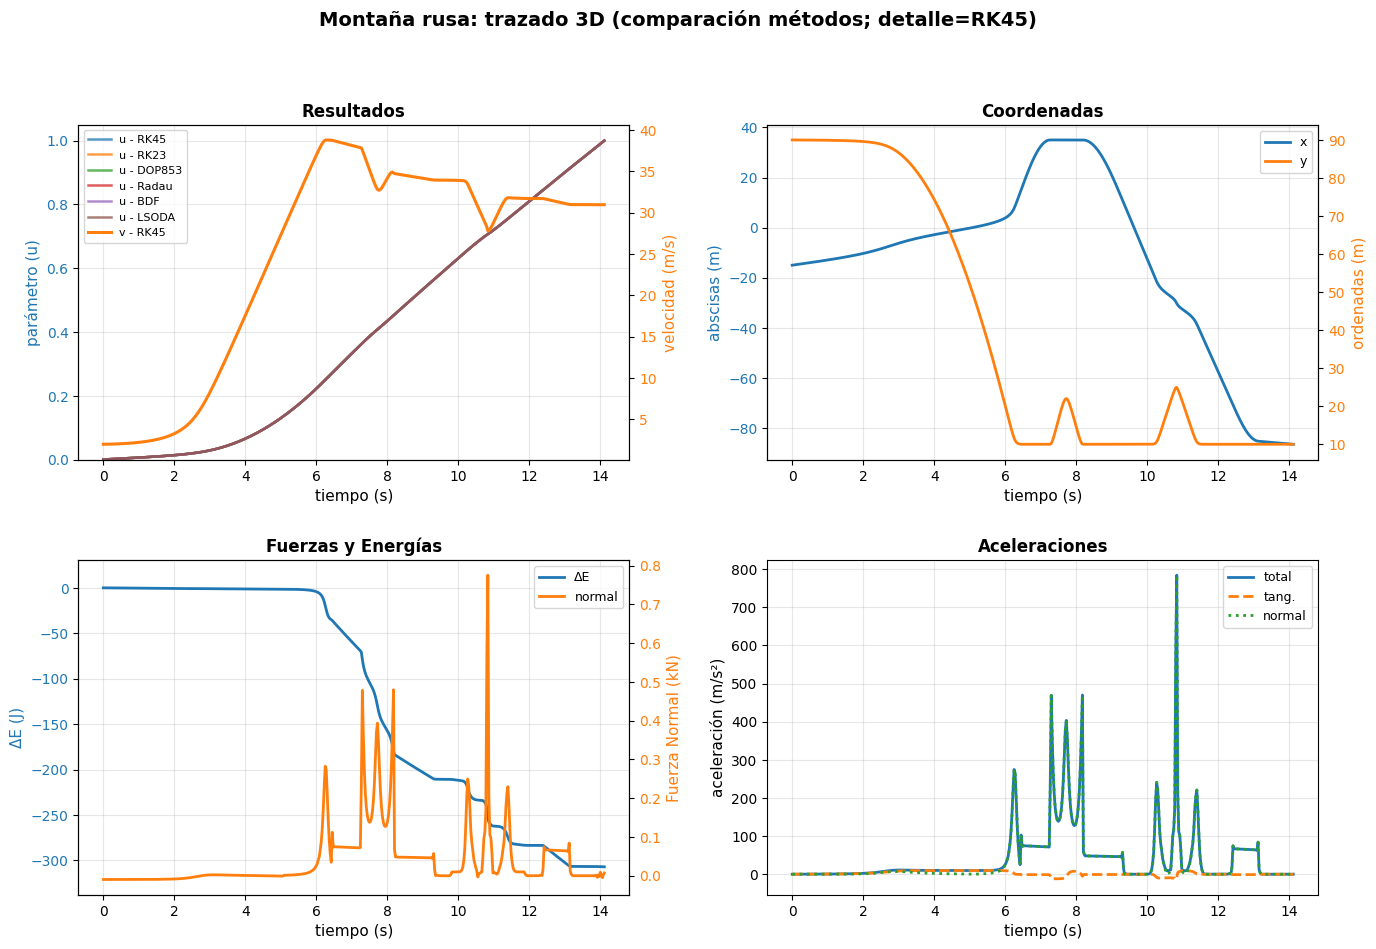


ESTADÍSTICAS DEL RECORRIDO
Método usado en detalle: RK45
Tiempo total:           14.11 s
Velocidad máxima:       38.78 m/s (139.60 km/h)
Velocidad media:        24.63 m/s (88.68 km/h)
Aceleración máxima:     784.19 m/s² (79.94 g)
Fuerza normal máxima:   775.17 N/kg (79.02 g)
Energía inicial:        884.47 J/kg
Energía final:          577.46 J/kg
Pérdida de energía:     34.71 %


In [35]:
# -*- coding: utf-8 -*-
# =====================================================================
# PARÁMETROS DEL PROBLEMA (igual que tu código)
# =====================================================================

g = 9.81
mu = 0.015
ca = 0.0
Sf = 2.0
rho_aire = 1.225
masa = 800.0

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

y0 = [0.0, 2.0]   # [u(0), v(0)]
t_end = 40.0

rtol = 1e-6
atol = 1e-9

# Comparación de métodos (mínimo cambio)
metodos = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
resultados = {}

# =====================================================================
# RESOLVER LA EDO PARA TODOS LOS MÉTODOS
# =====================================================================

print("\n" + "="*80)
print("RESOLVIENDO PARA VARIOS MÉTODOS...")
print("="*80)

for metodo in metodos:
    print(f"\nResolviendo con método {metodo}...")

    try:
        sol = solve_ivp(
            edofun_mr_wrapper,
            t_span=(0.0, t_end),
            y0=y0,
            args=(derivs, coefRoz, coefVis, g),
            method=metodo,
            events=[finalVia_wrapper, paradaVagon_wrapper],
            dense_output=True,
            rtol=rtol,
            atol=atol
        )

        if not sol.success:
            resultados[metodo] = {"ok": False, "error": sol.message}
            print(f"✗ FALLÓ: {sol.message}")
            continue

        resultados[metodo] = {"ok": True, "sol": sol}
        print("✓ Solución obtenida exitosamente")
        print(f"  Número de pasos: {len(sol.t)}")
        print(f"  Tiempo final: {sol.t[-1]:.2f} s")
        print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
        print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

        if sol.t_events[0].size > 0:
            print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
        if sol.t_events[1].size > 0:
            print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

    except Exception as e:
        resultados[metodo] = {"ok": False, "error": f"{type(e).__name__}: {e}"}
        print(f"✗ EXCEPCIÓN: {type(e).__name__}: {e}")

# Elegir método para gráficos detallados (mínimo cambio)
metodos_ok = [m for m in metodos if resultados[m].get("ok", False)]
if len(metodos_ok) == 0:
    raise RuntimeError("Ningún método ha producido una solución válida.")

# Método principal para cálculos caros (energía, fuerzas, aceleraciones)
metodo_plot = metodos_ok[0]   # o fija: metodo_plot = "Radau"
sol = resultados[metodo_plot]["sol"]

print("\n" + "="*80)
print(f"Usando '{metodo_plot}' para gráficos detallados (fuerzas/energías/aceleraciones)")
print("="*80)

# =====================================================================
# PREPARAR DATOS PARA GRAFICADO (igual que tu código)
# =====================================================================

n_puntos = 500
titulo = f"Montaña rusa: trazado 3D (comparación métodos; detalle={metodo_plot})"

time = np.linspace(0, sol.t[-1], n_puntos)
data = sol.sol(time)
u = data[0]
v = data[1]

# Calcular posición espacial
posicion = curva(u)

print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    x = posicion[0, :]
    y = posicion[2, :]
elif posicion.shape[1] == 3:
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# =====================================================================
# CALCULAR ENERGÍAS, FUERZAS Y ACELERACIONES (solo para metodo_plot)
# =====================================================================

E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)

        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN

        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis,
                                        fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr

    except Exception as e:
        print(f"Error en punto {i}: {e}")
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# =====================================================================
# FIGURA CON 4 SUBPLOTS (mínimo cambio)
# =====================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ---------------------------------------------------------------------
# SUBPLOT 1: u(t) y v(t) - aquí SÍ superponemos métodos
# ---------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Ploteo u(t) para todos los métodos OK
for m in metodos_ok:
    sol_m = resultados[m]["sol"]
    time_m = np.linspace(0, sol_m.t[-1], n_puntos)
    data_m = sol_m.sol(time_m)
    ax1.plot(time_m, data_m[0], linewidth=1.8, alpha=0.75, label=f"u - {m}")

ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Ploteo v(t) solo para el método principal (para no saturar)
ax1_twin.plot(time, v, color=color_v, linewidth=2.2, label=f"v - {metodo_plot}")

# Leyenda (u de todos + v principal)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax1_twin.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best', fontsize=8)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 2: x(t) y y(t) (aquí seguimos tu formato; método principal)
# ---------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 3: ΔE y Fuerza normal (método principal)
# ---------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

E0_kJ = E_total[0] / 1000.0
dE_J = (E_total / 1000.0 - E0_kJ) * 1000

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

dE_min = float(np.min(dE_J))
dE_max = float(np.max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0
margin = 0.10 * span
ax3.set_ylim(dE_min - margin, dE_max + margin)

ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal / 1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 4: Aceleraciones (método principal)
# ---------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# ESTADÍSTICAS (método principal)
# =====================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Método usado en detalle: {metodo_plot}")
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")

print("="*70)



RESOLVIENDO PARA VARIOS MÉTODOS...

Resolviendo con método RK45...
✓ Solución obtenida exitosamente
  Número de pasos: 131
  Tiempo final: 15.04 s
  Posición final: u = 1.0000
  Velocidad final: v = 25.95 m/s
  ✓ Evento 'finalVia' activado en t = 15.04 s

Resolviendo con método RK23...
✓ Solución obtenida exitosamente
  Número de pasos: 504
  Tiempo final: 15.04 s
  Posición final: u = 1.0000
  Velocidad final: v = 25.95 m/s
  ✓ Evento 'finalVia' activado en t = 15.04 s

Resolviendo con método DOP853...
✓ Solución obtenida exitosamente
  Número de pasos: 200
  Tiempo final: 15.04 s
  Posición final: u = 1.0000
  Velocidad final: v = 25.95 m/s
  ✓ Evento 'finalVia' activado en t = 15.04 s

Resolviendo con método Radau...
✓ Solución obtenida exitosamente
  Número de pasos: 502
  Tiempo final: 15.04 s
  Posición final: u = 1.0000
  Velocidad final: v = 25.95 m/s
  ✓ Evento 'finalVia' activado en t = 15.04 s

Resolviendo con método BDF...
✓ Solución obtenida exitosamente
  Número de pasos

C:\Users\miguel\AppData\Local\Temp\ipykernel_2344\4227601129.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


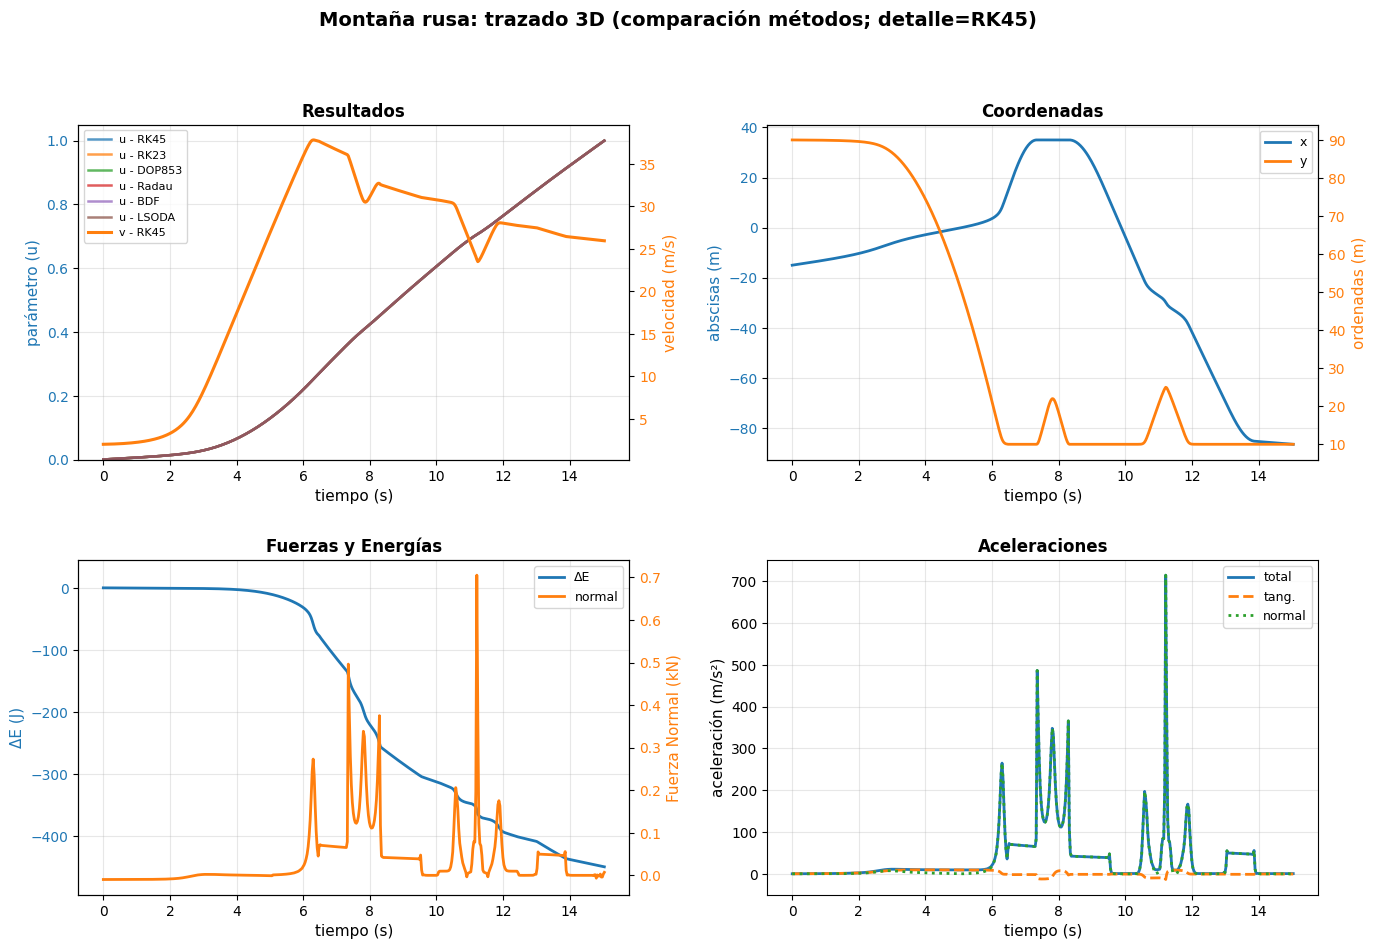


ESTADÍSTICAS DEL RECORRIDO
Método usado en detalle: RK45
Tiempo total:           15.04 s
Velocidad máxima:       37.81 m/s (136.13 km/h)
Velocidad media:        23.10 m/s (83.17 km/h)
Aceleración máxima:     714.90 m/s² (72.87 g)
Fuerza normal máxima:   705.34 N/kg (71.90 g)
Energía inicial:        884.47 J/kg
Energía final:          435.16 J/kg
Pérdida de energía:     50.80 %


In [ ]:
# -*- coding: utf-8 -*-
# =====================================================================
# PARÁMETROS DEL PROBLEMA (igual que tu código)
# =====================================================================

g = 9.81
mu = 0.015
ca = 0.4
Sf = 2.0
rho_aire = 1.225
masa = 800.0

coefRoz = mu
coefVis = (ca * Sf * rho_aire) / (2 * masa)

y0 = [0.0, 2.0]   # [u(0), v(0)]
t_end = 40.0

rtol = 1e-6
atol = 1e-9

# Comparación de métodos (mínimo cambio)
metodos = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]
resultados = {}

# =====================================================================
# RESOLVER LA EDO PARA TODOS LOS MÉTODOS
# =====================================================================

print("\n" + "="*80)
print("RESOLVIENDO PARA VARIOS MÉTODOS...")
print("="*80)

for metodo in metodos:
    print(f"\nResolviendo con método {metodo}...")

    try:
        sol = solve_ivp(
            edofun_mr_wrapper,
            t_span=(0.0, t_end),
            y0=y0,
            args=(derivs, coefRoz, coefVis, g),
            method=metodo,
            events=[finalVia_wrapper, paradaVagon_wrapper],
            dense_output=True,
            rtol=rtol,
            atol=atol
        )

        if not sol.success:
            resultados[metodo] = {"ok": False, "error": sol.message}
            print(f"✗ FALLÓ: {sol.message}")
            continue

        resultados[metodo] = {"ok": True, "sol": sol}
        print("✓ Solución obtenida exitosamente")
        print(f"  Número de pasos: {len(sol.t)}")
        print(f"  Tiempo final: {sol.t[-1]:.2f} s")
        print(f"  Posición final: u = {sol.y[0][-1]:.4f}")
        print(f"  Velocidad final: v = {sol.y[1][-1]:.2f} m/s")

        if sol.t_events[0].size > 0:
            print(f"  ✓ Evento 'finalVia' activado en t = {sol.t_events[0][0]:.2f} s")
        if sol.t_events[1].size > 0:
            print(f"  ⚠ Evento 'paradaVagon' activado en t = {sol.t_events[1][0]:.2f} s")

    except Exception as e:
        resultados[metodo] = {"ok": False, "error": f"{type(e).__name__}: {e}"}
        print(f"✗ EXCEPCIÓN: {type(e).__name__}: {e}")

# Elegir método para gráficos detallados (mínimo cambio)
metodos_ok = [m for m in metodos if resultados[m].get("ok", False)]
if len(metodos_ok) == 0:
    raise RuntimeError("Ningún método ha producido una solución válida.")

# Método principal para cálculos caros (energía, fuerzas, aceleraciones)
metodo_plot = metodos_ok[0]   # o fija: metodo_plot = "Radau"
sol = resultados[metodo_plot]["sol"]

print("\n" + "="*80)
print(f"Usando '{metodo_plot}' para gráficos detallados (fuerzas/energías/aceleraciones)")
print("="*80)

# =====================================================================
# PREPARAR DATOS PARA GRAFICADO (igual que tu código)
# =====================================================================

n_puntos = 500
titulo = f"Montaña rusa: trazado 3D (comparación métodos; detalle={metodo_plot})"

time = np.linspace(0, sol.t[-1], n_puntos)
data = sol.sol(time)
u = data[0]
v = data[1]

# Calcular posición espacial
posicion = curva(u)

print(f"\nForma de posicion: {posicion.shape}")

# Extraer coordenadas correctamente según la forma del array
if posicion.ndim == 1:
    x = np.full(n_puntos, posicion[0])
    y = np.full(n_puntos, posicion[2])
elif posicion.shape[0] == 3:
    x = posicion[0, :]
    y = posicion[2, :]
elif posicion.shape[1] == 3:
    x = posicion[:, 0]
    y = posicion[:, 2]
else:
    raise ValueError(f"Forma de posicion no esperada: {posicion.shape}")

print(f"Forma de x: {x.shape}, Forma de y: {y.shape}")
print(f"Forma de time: {time.shape}, Forma de u: {u.shape}, Forma de v: {v.shape}")

# =====================================================================
# CALCULAR ENERGÍAS, FUERZAS Y ACELERACIONES (solo para metodo_plot)
# =====================================================================

E_total = np.zeros(n_puntos)
F_normal = np.zeros(n_puntos)
a_total = np.zeros(n_puntos)
a_tang = np.zeros(n_puntos)
a_normal = np.zeros(n_puntos)

print("Calculando fuerzas, energías y aceleraciones...")
for i in range(n_puntos):
    try:
        E_total[i] = energia(u[i], v[i], derivs[0], grav=g)

        fuerzaN, baseLocal, ctes = fuerzaNormal(u[i], v[i], derivs, grav=g)
        F_normal[i] = fuerzaN

        a_tot, a_tg, a_nr = aceleracion(v[i], baseLocal, coefRoz, coefVis,
                                        fuerzaN, ctes[1], grav=g)
        a_total[i] = a_tot
        a_tang[i] = a_tg
        a_normal[i] = a_nr

    except Exception as e:
        print(f"Error en punto {i}: {e}")
        if i > 0:
            E_total[i] = E_total[i-1]
            F_normal[i] = F_normal[i-1]
            a_total[i] = a_total[i-1]
            a_tang[i] = a_tang[i-1]
            a_normal[i] = a_normal[i-1]

print("✓ Cálculos completados")

# =====================================================================
# FIGURA CON 4 SUBPLOTS (mínimo cambio)
# =====================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# ---------------------------------------------------------------------
# SUBPLOT 1: u(t) y v(t) - aquí SÍ superponemos métodos
# ---------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

color_u = 'tab:blue'
ax1.set_xlabel('tiempo (s)', fontsize=11)
ax1.set_ylabel('parámetro (u)', color=color_u, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color_u)
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Ploteo u(t) para todos los métodos OK
for m in metodos_ok:
    sol_m = resultados[m]["sol"]
    time_m = np.linspace(0, sol_m.t[-1], n_puntos)
    data_m = sol_m.sol(time_m)
    ax1.plot(time_m, data_m[0], linewidth=1.8, alpha=0.75, label=f"u - {m}")

ax1_twin = ax1.twinx()
color_v = 'tab:orange'
ax1_twin.set_ylabel('velocidad (m/s)', color=color_v, fontsize=11)
ax1_twin.tick_params(axis='y', labelcolor=color_v)

# Ploteo v(t) solo para el método principal (para no saturar)
ax1_twin.plot(time, v, color=color_v, linewidth=2.2, label=f"v - {metodo_plot}")

# Leyenda (u de todos + v principal)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax1_twin.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best', fontsize=8)

ax1.set_title('Resultados', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 2: x(t) y y(t) (aquí seguimos tu formato; método principal)
# ---------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

color_x = 'tab:blue'
ax2.set_xlabel('tiempo (s)', fontsize=11)
ax2.set_ylabel('abscisas (m)', color=color_x, fontsize=11)
line1 = ax2.plot(time, x, color=color_x, linewidth=2, label='x')
ax2.tick_params(axis='y', labelcolor=color_x)
ax2.grid(True, alpha=0.3)

ax2_twin = ax2.twinx()
color_y = 'tab:orange'
ax2_twin.set_ylabel('ordenadas (m)', color=color_y, fontsize=11)
line2 = ax2_twin.plot(time, y, color=color_y, linewidth=2, label='y')
ax2_twin.tick_params(axis='y', labelcolor=color_y)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best', fontsize=9)

ax2.set_title('Coordenadas', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 3: ΔE y Fuerza normal (método principal)
# ---------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

E0_kJ = E_total[0] / 1000.0
dE_J = (E_total / 1000.0 - E0_kJ) * 1000

color_E = 'tab:blue'
ax3.set_xlabel('tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J)', color=color_E, fontsize=11)
line1 = ax3.plot(time, dE_J, color=color_E, linewidth=2, label='ΔE')
ax3.tick_params(axis='y', labelcolor=color_E)
ax3.grid(True, alpha=0.3)

dE_min = float(np.min(dE_J))
dE_max = float(np.max(dE_J))
span = dE_max - dE_min
if span == 0:
    span = 1.0
margin = 0.10 * span
ax3.set_ylim(dE_min - margin, dE_max + margin)

ax3_twin = ax3.twinx()
color_F = 'tab:orange'
ax3_twin.set_ylabel('Fuerza Normal (kN)', color=color_F, fontsize=11)
line2 = ax3_twin.plot(time, F_normal / 1000.0, color=color_F, linewidth=2, label='normal')
ax3_twin.tick_params(axis='y', labelcolor=color_F)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='best', fontsize=9)

ax3.set_title('Fuerzas y Energías', fontsize=12, fontweight='bold')

# ---------------------------------------------------------------------
# SUBPLOT 4: Aceleraciones (método principal)
# ---------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

ax4.set_xlabel('tiempo (s)', fontsize=11)
ax4.set_ylabel('aceleración (m/s²)', fontsize=11)

ax4.plot(time, a_total, linewidth=2, label='total', color='tab:blue')
ax4.plot(time, a_tang, linewidth=2, linestyle='--', label='tang.', color='tab:orange')
ax4.plot(time, a_normal, linewidth=2, linestyle=':', label='normal', color='tab:green')

ax4.grid(True, alpha=0.3)
ax4.legend(loc='best', fontsize=9)
ax4.set_title('Aceleraciones', fontsize=12, fontweight='bold')

fig.suptitle(titulo, fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =====================================================================
# ESTADÍSTICAS (método principal)
# =====================================================================
print("\n" + "="*70)
print("ESTADÍSTICAS DEL RECORRIDO")
print("="*70)
print(f"Método usado en detalle: {metodo_plot}")
print(f"Tiempo total:           {sol.t[-1]:.2f} s")
print(f"Velocidad máxima:       {np.max(v):.2f} m/s ({np.max(v)*3.6:.2f} km/h)")
print(f"Velocidad media:        {np.mean(v):.2f} m/s ({np.mean(v)*3.6:.2f} km/h)")
print(f"Aceleración máxima:     {np.max(a_total):.2f} m/s² ({np.max(a_total)/g:.2f} g)")
print(f"Fuerza normal máxima:   {np.max(F_normal):.2f} N/kg ({np.max(F_normal)/g:.2f} g)")
print(f"Energía inicial:        {E_total[0]:.2f} J/kg")
print(f"Energía final:          {E_total[-1]:.2f} J/kg")

if coefRoz > 0 or coefVis > 0:
    perdida = (E_total[0] - E_total[-1]) / E_total[0] * 100
    print(f"Pérdida de energía:     {perdida:.2f} %")
else:
    dE = np.abs(E_total - E_total[0]) / E_total[0]
    conservacion = np.max(dE) * 100
    print(f"Máx variación energía:  {conservacion:.4f} % (conservativo)")

print("="*70)
